# Frequency domain to time domain

Previously we have studied Electromagnetic plane waves that had a single frequency (we called them harmonic plane waves). But you are likely wondering how does this translate to the time-domain responses?

Let's consider a planewave who's initial amplitude in time is given by an impulse:

\begin{align}
\vec{E}(t=0) = \vec{E}_0\delta(t)
\end{align}

What happens to this field in time? How do we even analyze it? Do we even have a hope of getting a general solution??

Idea:

Fourier transform?

Laplace transform?

## Transient plane wave

\begin{align}
r = |z|/c\\
e^{a r} \delta(t-r) + \frac{a z e^{-at}}{c \sqrt{t^2 - r^2}} I_1\bigg[a\sqrt{t^2 - r^2} \bigg]u(t-r)
\end{align}


In [2]:
import numpy as np
from scipy.constants import mu_0, epsilon_0
import scipy.special as scf

import numba
from numba.extending import overload, get_cython_function_address
from numba import types
import ctypes

import matplotlib.pyplot as plt

import sympy as sp
from sympy.integrals.transforms import inverse_laplace_transform, laplace_transform, fourier_transform

In [3]:
m, s, x_sp, t_sp, o = sp.symbols('\mu,\sigma,z,t,\omega', positive=True, real=True)
d = sp.symbols('d', real=True, positive=True)

In [4]:
func_address = get_cython_function_address('scipy.special.cython_special', 'i1e')
func_type = ctypes.CFUNCTYPE(ctypes.c_double, ctypes.c_double)
c_func = func_type(func_address)

@overload(scf.i1e)
def i1e_numba(x):
    if isinstance(x, types.Float):
        def f(x):
            return c_func(x)
        return f

In [5]:
@numba.vectorize(nopython=True)
def impulse_response(t, r, a, c):
    rc = r/c
    #scale = 1/(4 * np.pi * r)
    if t == rc:
        # e^{-a * rc) * delta(t-rc)
        return np.inf
    elif t < rc:
        # t - r/c < 0
        return 0
    else:
        # t - r/c > 0
        sqrt = np.sqrt(t**2 - rc**2)
        v = a * sqrt
        log_part = -a * t + v + np.log(scf.i1e(v))
        out = a * rc * np.exp(log_part)/sqrt
        if out != out:
            # means there was very small (or large) input to the i1e.
            return 0
        else:
            return out

In [6]:
def model_impulse_response(t, z, sigma, eps, mu, E0=1):
    a = sigma/(2 * eps)
    c = 1.0/np.sqrt(mu * eps)
    out = E0 * impulse_response(t, np.abs(z), a, c)
    return out

In [7]:
def wave_position(z, eps, mu):
    return np.abs(z) * np.sqrt(eps * mu)

In [8]:
# value of C in m/ns?

In [9]:
sigma = 0.1
eps = epsilon_0
mu = mu_0

t = np.linspace(1, 2, 1024) * 1E-9 # 0 to 10ns
x = np.linspace(-0.5, 0.5, 1000)  # -5 to 5m

response = model_impulse_response(t[:, None], x[None, :], sigma, eps, mu)

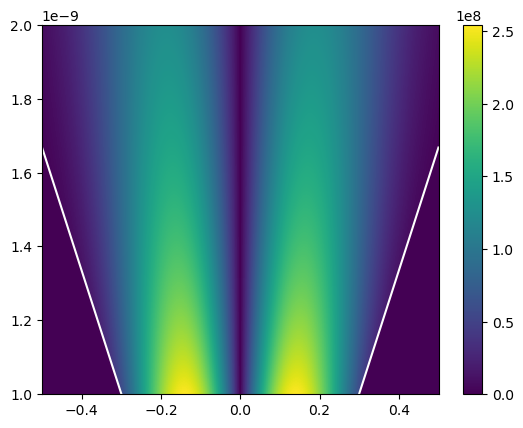

In [10]:
plt.figure()
ax = plt.gca()
im = ax.pcolormesh(x, t, response)
ys = ax.get_ylim()
xs = ax.get_xlim()

temp = np.r_[x[x<0], 0, x[x>0]]
wave_front = wave_position(temp, eps, mu)

ax.plot(temp, wave_front, color='w')
ax.set_ylim(ys)
ax.set_xlim(xs)
plt.colorbar(im)

## Clearly two parts here:
first is the Wave part, Travels with a speed dependent on $\varepsilon$ and $\mu$

Second is the diffused conductive part:
What speed does that thing travel?

Well, for most times of relevance, the diffused part follows:

In [11]:
m, s, x_sp, t_sp, o = sp.symbols('\mu,\sigma,z,t,\omega', positive=True, real=True)
d = sp.symbols('d', real=True, positive=True)

In [12]:
e_t = sp.sqrt(m * s)/(2 * sp.sqrt(sp.pi * t_sp) * t_sp) * z_sp * sp.exp(-m * s * z_sp**2/(4 * t_sp))
e_t

NameError: name 'z_sp' is not defined

## Peak time:
The time at which the diffusion part hits it's maximum:

In [ ]:
e_dt = e_t.diff(t_sp).simplify()
e_dt

In [13]:
e_dz = e_t.diff(z_sp).simplify()
e_dz

NameError: name 'e_t' is not defined

In [14]:
e_dt_amp = e_dt.subs(sp.exp(-m * s * z_sp**2/(4 * t_sp)), 1)
e_dz_amp = e_dz.subs(sp.exp(-m * s * z_sp**2/(4 * t_sp)), 1)
e_dz_amp

NameError: name 'e_dt' is not defined

In [15]:
peak_t = sp.solve(e_dt_amp, t_sp)[0]
peak_t

NameError: name 'e_dt_amp' is not defined

In [16]:
peak_z = sp.solve(e_dz_amp, z_sp)[0]
peak_z

NameError: name 'e_dz_amp' is not defined

In [17]:
peak_v = peak_z.diff(t_sp).simplify()
peak_v

NameError: name 'peak_z' is not defined

In [18]:
v_w = 2 * fourier_transform(peak_v, t_sp, o)
v_w.simplify()

NameError: name 'peak_v' is not defined

In [19]:
v_w_r, v_w_i = v_w.as_real_imag()
v_w_r

NameError: name 'v_w' is not defined

In [20]:
v_w_i

NameError: name 'v_w_i' is not defined

In [21]:
# what is this??
sp.sqrt(2/(m * s * o))

sqrt(2)/(sqrt(\mu)*sqrt(\omega)*sqrt(\sigma))

In [22]:
def quasi_maximum(z, t, vals):
    its = np.argmax(vals, axis=0)
    out = t[its]
    out[its == len(t)-1] = np.nan
    return out

def quasi_peak_time(z, sigma, mu):
    return mu * sigma * z**2/6

def quasi_peak_z(t, sigma, mu):
    return np.sqrt(2 * t/(mu * sigma))

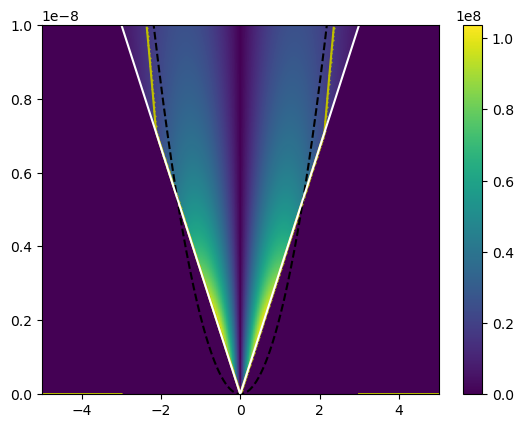

In [33]:
sigma = 1E-2
t = np.linspace(0, 1, 1024) * 1E-8 # 0 to 10ns
x = np.linspace(-5, 5, 1000)  # -5 to 5m

response = model_impulse_response(t[:, None], x[None, :], sigma, eps, mu)

plt.figure()
ax = plt.gca()
im = ax.pcolormesh(x, t, response)
ys = ax.get_ylim()
xs = ax.get_xlim()

# trace the maximum of vals at each time
ax.plot(x, quasi_maximum(x, t, response), color='y', linestyle=None, marker='.', markersize=1)

temp = np.r_[x[x<0], 0, x[x>0]]
#ax.plot(temp, quasi_position(temp, sigma, mu_0), color='y')
#ax.plot(quasi_position(t, sigma, mu_0), t, 'k')
ax.plot(temp, quasi_peak_time(temp, sigma, mu), color='k', linestyle='--')
ax.plot(temp, wave_position(temp, eps, mu), color='w')
ax.set_ylim(ys)
ax.set_xlim(xs)
plt.colorbar(im)

4.887585532746823e-09


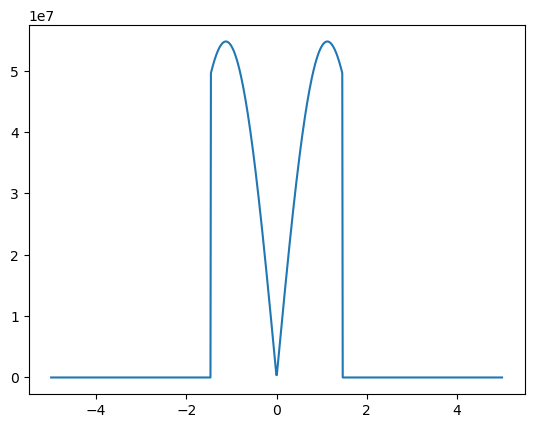

In [34]:
i_time = 500

print(t[i_time])
plt.plot(x, response[i_time])